# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [14]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.01 # швидкість навчання нейронної мережі
training_steps = 10000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 1024 # кількість нейронів 1-го шару
n_hidden_2 = 2048 # кількість нейронів 2-го шару

In [15]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [16]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes)

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=1)
    x = self.layer2(x, activation=1)
    x = self.out_layer(x, activation=1)
    return x


In [17]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Порівняємо передбачені мітки зі справжніми мітками
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Перетворимо булеві значення на числа та обчислимо середню точність
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [18]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")
optimizer = tf.optimizers.Adam(learning_rate)

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  optimizer = tf.optimizers.SGD(learning_rate)

  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

  trainable_variables = neural_net.trainable_variables
  gradients = g.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, accuracy(pred, output_y)


In [19]:

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

# Перетворюємо зображення в 4D масив (зразок, рядок, стовпець, канали)
x_train = x_train.reshape((-1, 28, 28, 1))

# Налаштовуємо генератор
datagen.fit(x_train)

# Отримуємо ітератор для аугментованих зображень
augmented_iterator = datagen.flow(x_train, y_train, batch_size=batch_size)

In [20]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    with tf.GradientTape() as g:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        
    trainable_variables = neural_net.trainable_variables
    gradients = g.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    if step % display_step == 0:
        print(f"Step {step}, Loss: {loss}")


Step 100, Loss: 261.09051513671875
Step 200, Loss: 130.09381103515625
Step 300, Loss: 123.22576904296875
Step 400, Loss: 88.87069702148438
Step 500, Loss: 80.2148666381836
Step 600, Loss: 84.58236694335938
Step 700, Loss: 75.64799499511719
Step 800, Loss: 66.00102996826172
Step 900, Loss: 85.79707336425781
Step 1000, Loss: 94.89275360107422
Step 1100, Loss: 97.35054016113281
Step 1200, Loss: 53.19193649291992
Step 1300, Loss: 66.06130981445312
Step 1400, Loss: 45.666202545166016
Step 1500, Loss: 50.27658462524414
Step 1600, Loss: 70.83485412597656
Step 1700, Loss: 56.68584442138672
Step 1800, Loss: 41.163734436035156
Step 1900, Loss: 74.3856201171875
Step 2000, Loss: 32.39292907714844
Step 2100, Loss: 67.922119140625
Step 2200, Loss: 41.481536865234375
Step 2300, Loss: 43.1599235534668
Step 2400, Loss: 35.387020111083984
Step 2500, Loss: 56.47761917114258
Step 2600, Loss: 39.096797943115234
Step 2700, Loss: 16.4327335357666
Step 2800, Loss: 49.877052307128906
Step 2900, Loss: 36.643962

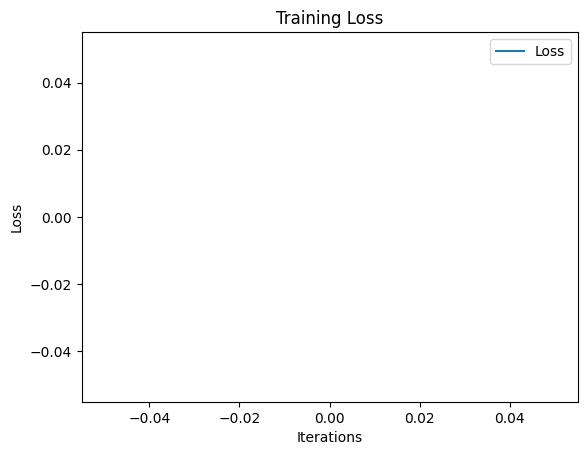

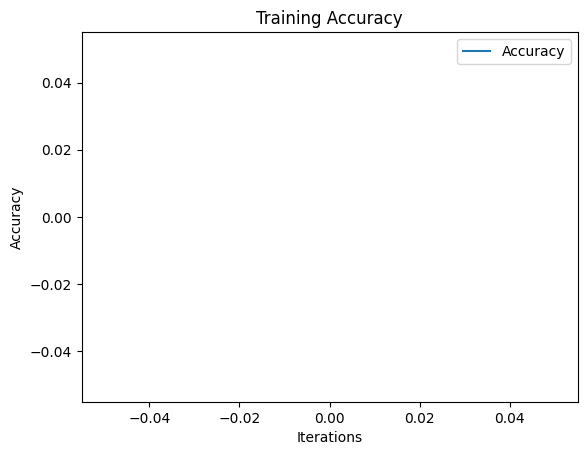

In [21]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

plt.plot(loss_history, label='Loss')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(accuracy_history, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [22]:
def test(neural_net, input_x, output_y):
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    acc = accuracy(pred, output_y)
    return loss, acc

test_loss, test_acc = test(neural_net, x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


Test Loss: 2221.85693359375, Test Accuracy: 0.9567999839782715


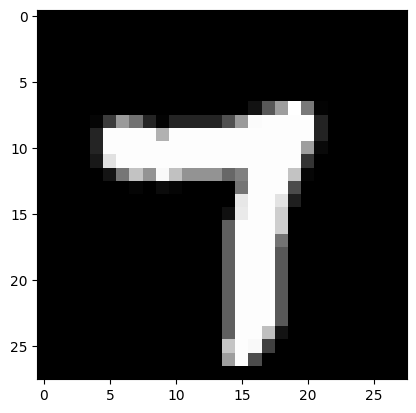

Predicted Label: 7, True Label: 7


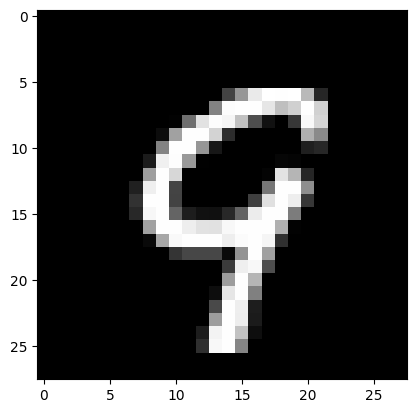

Predicted Label: 9, True Label: 9


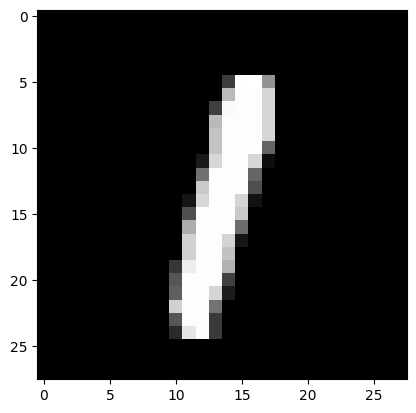

Predicted Label: 1, True Label: 1


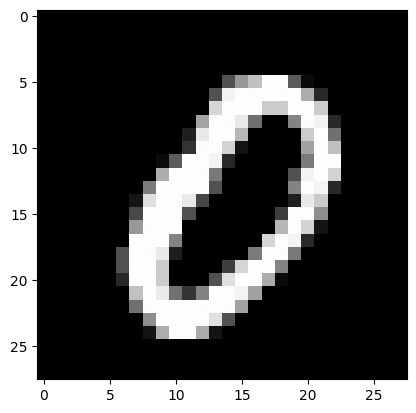

Predicted Label: 0, True Label: 0


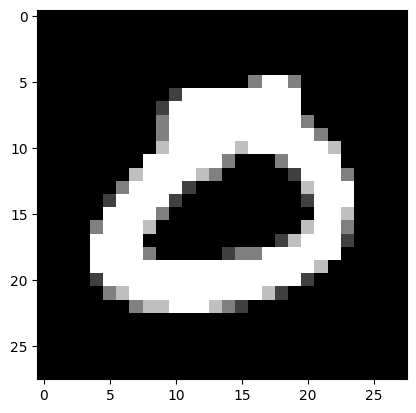

Predicted Label: 0, True Label: 0


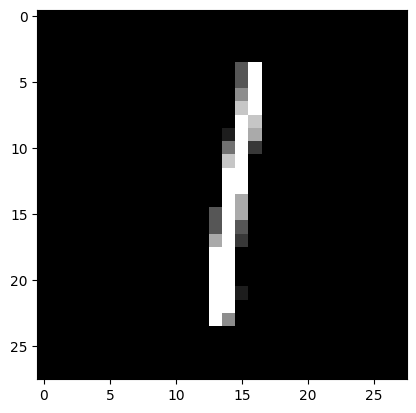

Predicted Label: 1, True Label: 1


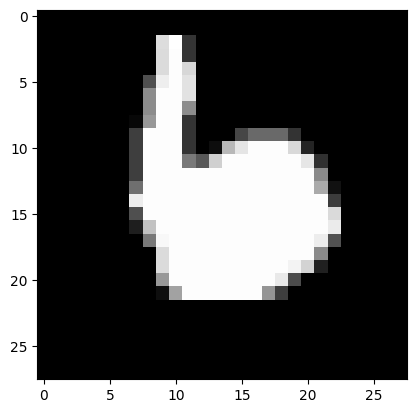

Predicted Label: 6, True Label: 6


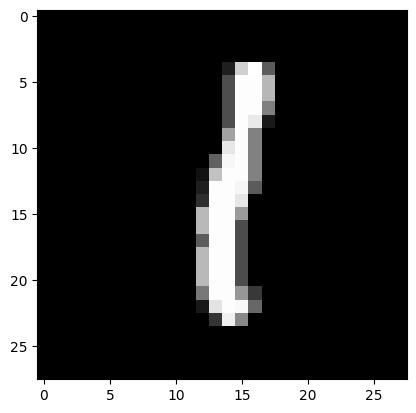

Predicted Label: 1, True Label: 1


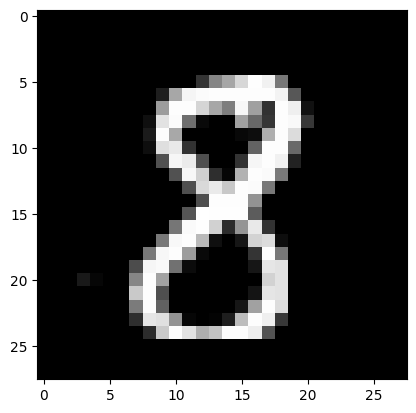

Predicted Label: 8, True Label: 8


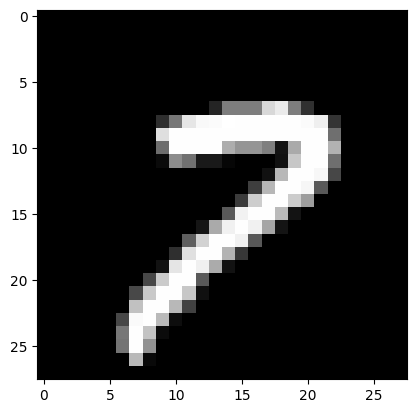

Predicted Label: 7, True Label: 7


In [23]:
random_indices = random.sample(range(len(x_test)), 10)

for idx in random_indices:
    image = x_test[idx].reshape((28, 28))
    plt.imshow(image, cmap='gray')
    plt.show()
    prediction = np.argmax(neural_net(x_test[idx:idx+1]))
    print(f"Predicted Label: {prediction}, True Label: {y_test[idx]}")





In [24]:
from sklearn.metrics import classification_report

# Отримуємо прогнозовані мітки з нашої моделі
y_pred = [np.argmax(neural_net(x_test[i:i+1])) for i in range(len(x_test))]

# Використовуємо функцію classification_report для отримання звіту про класифікацію
report = classification_report(y_test, y_pred)

# Виводимо звіт
print(report)


              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.94      0.94      0.94      1010
           4       0.95      0.95      0.95       982
           5       0.94      0.94      0.94       892
           6       0.97      0.96      0.97       958
           7       0.95      0.96      0.95      1028
           8       0.95      0.94      0.95       974
           9       0.95      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

